In [1]:
# Import stuff we'll need later
import numpy as np
from scipy.signal import lfilter, lfilter_zi, freqz, kaiserord, firwin

%matplotlib inline
import matplotlib.pyplot as plt

Document version 1.0, 2019-12-28

# The FIR Filter

The [FIR filter](https://en.wikipedia.org/wiki/Finite_impulse_response) is a filter whos response to an [impulse](https://en.wikipedia.org/wiki/Impulse_response) input settles to zero in some finite amount of time. Or put more generally, it cannot oscillate. Intutively this can be seen as the output of the FIR filter depends only on previous measurements and not previous outputs, it has no output feedback.

For a [causal discrete-time](https://en.wikipedia.org/wiki/Causal_filter) FIR filter of order N, the output of the filter is a weighted sum of the N most recent inputs. For now we'll ignore [non-causal](https://en.wikipedia.org/wiki/Causal_system) filters since they're not very practical.

$$\begin{equation}
\begin{split}
y_{n} &= b_{0} x_{n}+b_{1} x_{n-1} + \dots + b_{N} x_{n-N} \\
&= \sum_{i=0}^{N} b_{i} \cdot x_{n-1}
\end{split}
\end{equation}$$

where

* $x_n$ is the input signal
* $y_n$ is the output signal
* $N$ is the filter order; note that an $N$-th order filter has $(N+1)$ terms on the right-hand side. In other words a 5-th order filter will have 6 taps, or terms, on the right-hand side
* $b_i$ is the value of the impulse response at the $i$-th instant for $0 \le i \le N$ of an $N$-th order FIR filter. If the filter is a [direct form](https://www.dsprelated.com/freebooks/filters/Direct_Form_I.html) FIR filter than $b_i$ is also a coefficient of the filter

This computation is also known as [discrete convolution](https://en.wikipedia.org/wiki/Convolution)

## Filter Design Example

Let's see how this works in practice. Take a look at the code below to see how we set up our filter.

While desinging our filter the fitler has no notion of "[sampling frequency](https://en.wikipedia.org/wiki/Sampling_(signal_processing))", rather our [passband](https://en.wikipedia.org/wiki/Passband) and [cutoff](https://en.wikipedia.org/wiki/Cutoff_frequency) regions are normalized to the [Nyquist Rate](https://en.wikipedia.org/wiki/Nyquist_rate). An other way to think of it is that the filter coefficents are normalized to the sampling rate, whatever that may be. For example, if we were to double the rate at which we pass samples through our filter, the passband and cutoff frequencies will also be doubled.

In [2]:
Fs = 100 # sample rate [Hz]
nyq_rate = Fs / 2 # nyquist rate

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.
width = 5 / nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 40

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 10

# Use firwin with a Kaiser window to create a lowpass FIR filter.
a = [1] # poles, an FIR filter has none
b = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta)) # zeros

After designing our filter we are left with the ["poles" and "zeros"](https://web.mit.edu/2.14/www/Handouts/PoleZero.pdf), $a$ and $b$, respecitvely. Along with the sampling frquency these coefficients completely describe the filter. Maybe you've noticed in the difference equation above that the FIR Filter only has "zeros", so why do we need to define $a = [1]$? Good question.

Consider the [Z-domain](https://en.wikipedia.org/wiki/Z-transform) transfer function of an [IIR Filter](https://en.wikipedia.org/wiki/Infinite_impulse_response)

$$\begin{equation}
\begin{split}
H(z) = \frac{Y(z)}{X(z)} &= \frac{b_0 + b_{1} z^{-1} + \cdots + b_{i}z^{-i}}{1 + a_0 + a_{1} z^{-1} + \cdots + a_{j}z^{-j}} \\
&= \frac{\sum_{i=0}^{N} b_{i}z^{-i}}{1 + \sum_{j=0}^{M} a_{j}z^{-j}}
\end{split}
\end{equation}$$

The FIR filter is a special case of the IIR filter in which all of the $a$ coefficients are 0, with a $1$ remaining in the denominator of the transfer funciton. Because of this, there is no function implemented in SciPy for the FIR filter, instead we use [*lfilter*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html) and specify the $a$ coefficients to simply equal $1$.

## Frequency Response

The [frequency response](https://en.wikipedia.org/wiki/Frequency_response) of a filter tells us how the filter will react to certain input frequencies. More specifically it lets us know how certain frequencies are attenuated or shifted in phase. Using the [*freqz*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html) function from SciPy we can easily view the frequency response of the filter.

In [3]:
# Calculate the frequency response 'h' at the complex frequencies 'w'
# Note that 'w' is returned in the same units as 'Fs'
w, h = freqz(b, a, worN=8192)

w_hz = w * (Fs/(2*np.pi)) # 'convert 'w' from radians to Hz
h_db = 20 * np.log10(np.abs(h)) # convert 'h' from complex magitude to dB
angles = np.unwrap(np.angle(h)) * (180/np.pi)

Text(0, 0.5, 'angle [deg]')

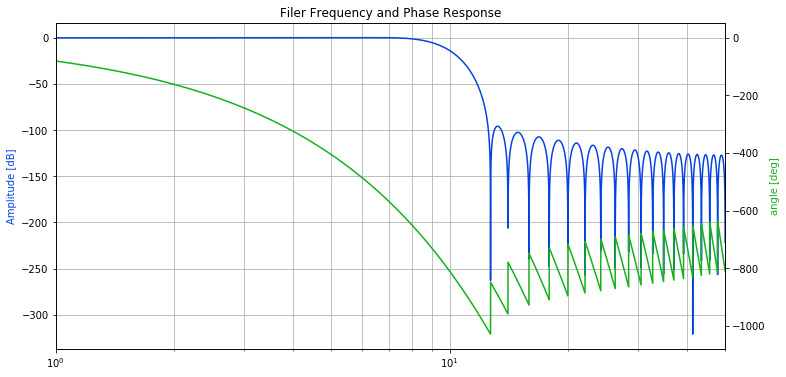

In [4]:
f = plt.figure(figsize=(12, 6))
ax1 = f.add_subplot(111)

ax1.plot(w_hz, 20*np.log(np.abs(h)), color='xkcd:blue')

ax1.set_xscale('log')
ax1.set_xlim([1, Fs/2])
ax1.grid(which='both', axis='both')
ax1.set_ylabel('Amplitude [dB]', color='xkcd:blue')
ax1.set_title('Filer Frequency and Phase Response')

ax2 = ax1.twinx()
ax2.plot(w_hz, angles, color='xkcd:green')
ax2.set_ylabel('angle [deg]', color='xkcd:green')

## Implementing an FIR Filter

Cool, now we know how to design an FIR filter but how do we implement the ourselves? Pretty simple, just implement the difference equation!

In [5]:
def fir_filter(xx, b):
    yy = np.zeros_like(xx)  # create buffer for output values
    delay = np.zeros_like(b)  # create delay line
    
    for ii, x in enumerate(xx):
        delay[1:] = delay[:-1]  # right-shift values in 'delay'
        delay[:1] = x  # place new value into the delay line
        yy[ii] = np.sum(delay * b)
    
    return yy

## Using the Filter

Below we create an example signal with two frequency components. One at $2Hz$ and one at $20Hz$. We've designed our example filter with a passband at $5Hz$ and the cutoff at $10Hz$, after applyting the filter we should only see the $2Hz$ signal remain.

Below we'll use both our implementation of the FIR Filter and the [lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html) implementation from SciPy. Note that the output from the two are equal.

In [6]:
# Create a sample signal
sig_len_s = 2 # sample signal length [seconds]
F1 = 2  # Simulated signal frequency 1 [Hz]
F2 = 20  # Simulated signal frequency 2 [Hz]

tt = np.arange(0, sig_len_s * Fs) * (1/Fs)
yy = np.sin(2*np.pi*F1*tt) + np.sin(2*np.pi*F2*tt)

In [7]:
# Filter our raw signal 'yy' with the FIR filter we've created
yy_filt = lfilter(b, a, yy)

# Use our implementation of the FIR filter
yy_filt2 = fir_filter(yy, b)

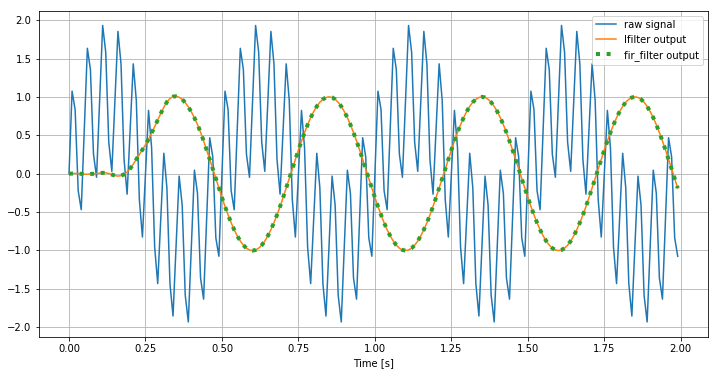

In [8]:
# Plot the raw signal and the filtered signal
f = plt.figure(figsize=(12, 6))
ax = f.add_subplot(111)
ax.plot(tt, yy, label='raw signal')
ax.plot(tt, yy_filt, label='lfilter output')
ax.plot(tt, yy_filt2, linewidth = 4, linestyle=':', label='fir_filter output')
ax.legend()
ax.set_xlabel('Time [s]')
ax.grid(which='both', axis='both')